权重衰减等价于 L2 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。我们先描述 L2 范数正则化，再解释它为何又称权重衰减。

L2 范数正则化在模型原损失函数基础上添加 L2 范数惩罚项，从而得到训练所需要最小化的函数。 L2 范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。

In [1]:
%matplotlib inline
from mxnet import autograd, nd, init, gluon
from mxnet.gluon import loss as gloss, data as gdata, nn
import common as comm

In [2]:
#构造测试集
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [3]:
def init_parmas():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [4]:
def l2_penalty(w):
    return (w ** 2).sum()/2

In [5]:
w = nd.random.exponential(1,(2,2))
print(w)
print(w ** 2)
print(l2_penalty(w))


[[0.8418809  0.150791  ]
 [0.52287    0.03378678]]
<NDArray 2x2 @cpu(0)>

[[0.7087635  0.02273793]
 [0.27339303 0.00114155]]
<NDArray 2x2 @cpu(0)>

[0.50301796]
<NDArray 1 @cpu(0)>


In [28]:
batch_size, num_epochs, lr = 2, 100, 0.003
net, loss = comm.linreg, comm.squared_loss
train_iter = gdata.DataLoader(dataset=gdata.ArrayDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)

In [29]:
def fit_and_plot(lambd):
    w, b = init_parmas()
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            comm.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    comm.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

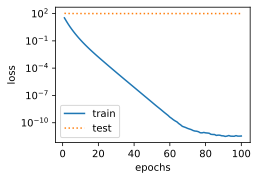

L2 norm of w: 14.0227995


In [30]:
# 当lambd设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。
fit_and_plot(0)

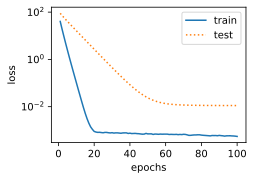

L2 norm of w: 0.039890718


In [31]:
fit_and_plot(3)

In [32]:
#简化模型
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma = 1))
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 
                              'sgd', {'learning_rate':lr, 'wd':wd})
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 
                              'sgd', {'learning_rate':lr})
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            train_w.step(batch_size)
            train_b.step(batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    comm.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', trainer_w.norm().asscalar())

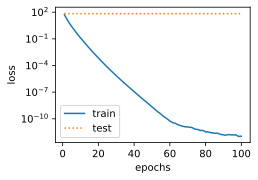

L2 norm of w: 13.220147


In [33]:
fit_and_plot(lambd=0)

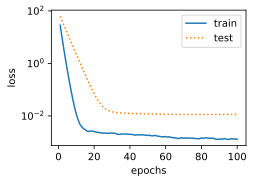

L2 norm of w: 0.030049087


In [34]:
fit_and_plot(lambd=6)

使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的 L2 范数比不使用权重衰减时的更小，此时的权重参数更接近0。
#### 结论
正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
权重衰减等价于 L2 范数正则化，通常会使学到的权重参数的元素较接近0。
权重衰减可以通过Gluon的wd超参数来指定。
可以定义多个Trainer实例对不同的模型参数使用不同的迭代方法。